## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Display limitation
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('./complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
# display 5 rows
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [5]:
# understand the column data type and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
# understand descriptive statistics of a data 
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [7]:
# Check percentage of missing or nan values
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened       0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [8]:
# understand the dimension of dataframe
df.shape

(78313, 22)

In [9]:
#Assign new column names
#Renames the columns of a DataFrame by removing leading underscores and the prefix "source." 
#from the column names
df.columns=[re.sub('^_','',column) for column in df.columns]
df.columns = [re.sub(r"^\bsource\b\.", "", column) for column in df.columns]

In [10]:
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [11]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("",np.nan,inplace=True)

In [12]:
# Check percentage of missing or nan values
round(df.isna().sum()*100/78313,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [13]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace= True)

In [14]:
# Check percentage of missing or nan values
round(df.isna().sum()*100/78313,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         22.03
zip_code                      5.93
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         0.18
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      26.90
sub_product                   2.69
timely                        0.00
complaint_what_happened       0.00
sub_issue                    10.44
consumer_consent_provided     0.00
dtype: float64

In [15]:
# understand the dimension of dataframe
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
"""
`clean_text` function provide a simple text cleaning function that performs 
several operations to remove unwanted elements from a given text
"""
def clean_text(text):
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [17]:
#Write your function to Lemmatize the texts
# Remove all unnecessary elements from `complaint_what_happened` column data and create a new DataFrame called `df_clean`
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [18]:
#Display the first few rows of the df_clean DataFrame
df_clean.head()

,complaint_what_happened
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number XXXX claim number is XXXX with chase


In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
# `lemmmatize_text` function Performs lemmatization on a given text using the spaCy library 
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [20]:
# Apply `lemmmatize_text` on df_clean dataframe.
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [21]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help,good morning my name be XXXX XXXX and I appreciate it if you could help I put a stop to Chase Bank cardmember service \n in I write to Chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n Chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account XXXX change my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX have the recording of the agent who be mislead I
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant,Chase Card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error,on while try to book a XXXX xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact XXXX and be refer to Chase Bank I then immediately contact Chase bank within no more than of get the notification on the screen and I be tell by the Chase representative I speak with that my application be deny but she could not st

In [22]:
#Write your function to extract the POS tags 
from textblob import TextBlob
""" 
`pos_tag` function uses the TextBlob library to perform part-of-speech (POS) 
 tagging on a given text and returns only the words tagged as nouns (NN)
 """
def pos_tag(text):
  # write your code here
    txtBlob = TextBlob(text)
    return ' '.join([ word for (word,tag) in txtBlob.tags if tag == "NN"])


df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['complaint_lemmatized']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help,good morning my name be XXXX XXXX and I appreciate it if you could help I put a stop to Chase Bank cardmember service \n in I write to Chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n Chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account XXXX change my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent XXXX recording agent
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant,Chase Card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,report application identity consent service credit identity applicant
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error,on while try to book a XXXX xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




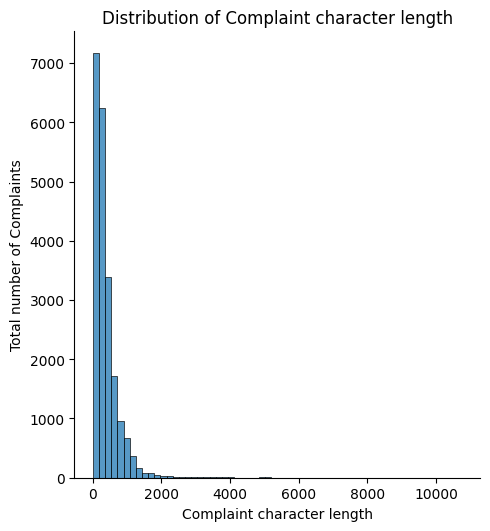

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
character_length = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(character_length, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

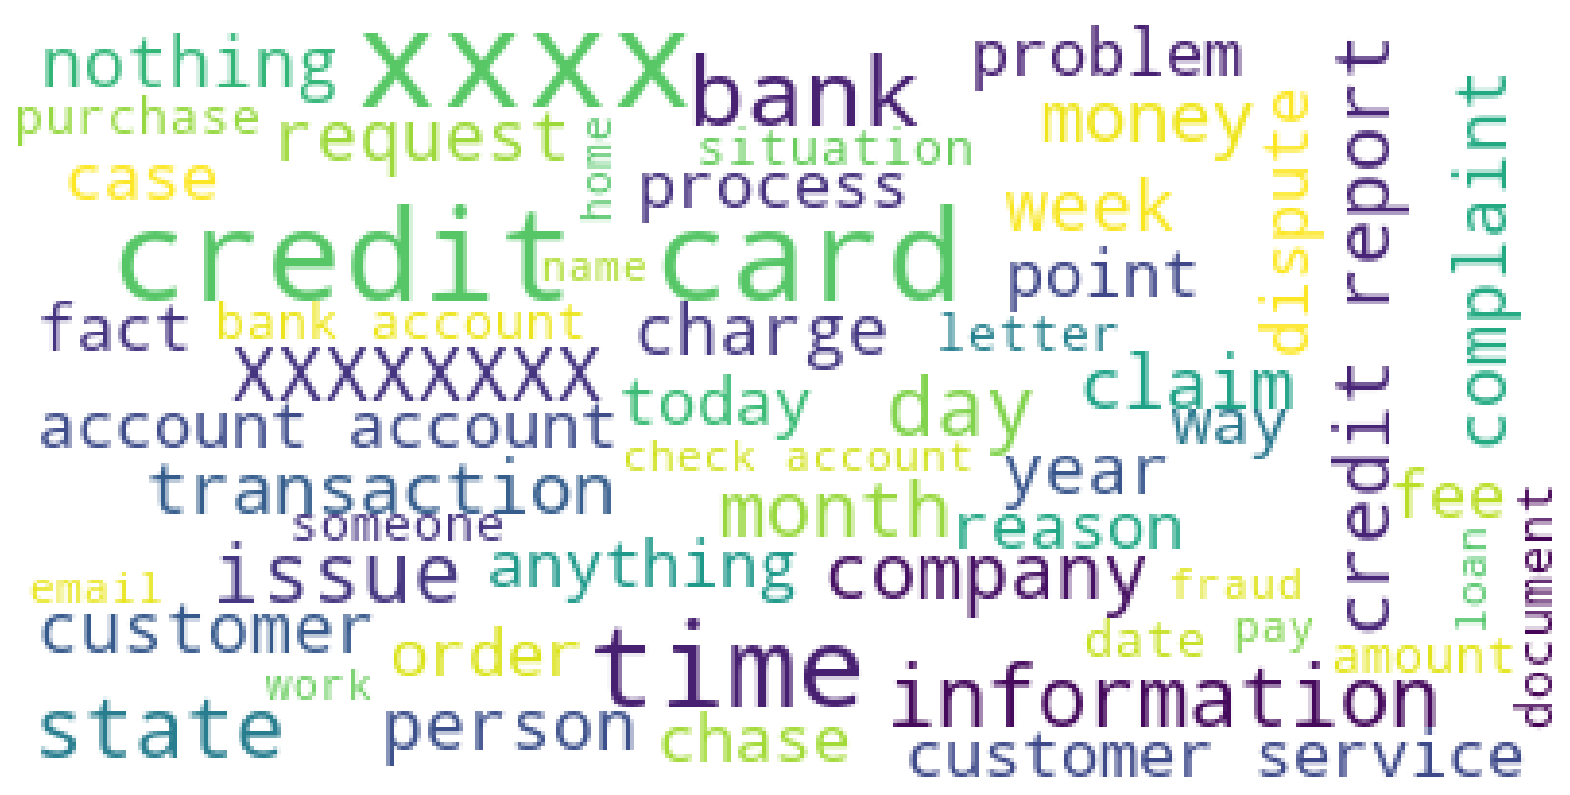

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
stopWords = set(STOPWORDS)
wordCloud = WordCloud(background_color='white',
                        stopwords=stopWords,max_font_size=36,max_words=54,random_state=42).generate(str(df_clean['complaint_POS_removed']))

figure = plt.figure(figsize=(20,18))
plt.imshow(wordCloud)
plt.axis('off')
plt.show()

In [26]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
# Creating a function to extract top unigrams based on given text input.
def get_top_unigram(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    bWords = vector.transform(text)
    sum_Words = bWords.sum(axis=0) 
    word_frequency = [(word, sum_Words[0, id]) for word, id in vector.vocabulary_.items()]
    word_frequency =sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [28]:
#Print the top 10 words in the unigram frequency
top_30_words = get_top_unigram(df_clean['Complaint_clean'].values.astype('U'))
df_unigram = pd.DataFrame(top_30_words, columns = ['Unigram' , 'Count'])
df_unigram.head(10)

,Unigram,Count
0,account,46432
1,credit,30982
2,card,26613
3,xxxx,22276
4,payment,20718
5,bank,18351
6,time,15756
7,charge,14872
8,day,12864
9,money,11890


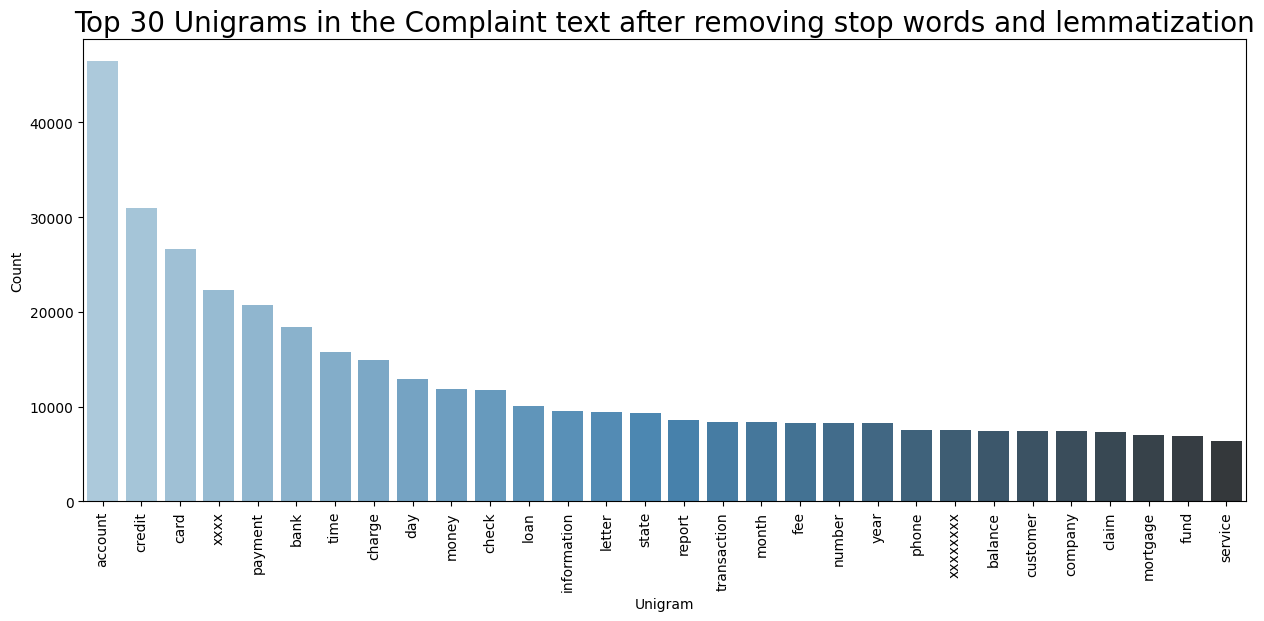

In [29]:
 # Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='Unigram', y='Count', data=df_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 Unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [30]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bWords = vector.transform(text)
    sum_Words = bWords.sum(axis=0) 
    word_frequency = [(word, sum_Words[0, id]) for word, id in vector.vocabulary_.items()]
    word_frequency =sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [31]:
#Print the top 10 words in the bigram frequency
top_30_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_30_words, columns = ['Bigram' , 'Count'])
df_bigram.head(10)

,Bigram,Count
0,credit card,11247
1,credit report,3741
2,account account,2826
3,customer service,2596
4,bank account,2234
5,check account,2118
6,xxxx xxxx,1755
7,card account,1574
8,account credit,1557
9,payment payment,1501


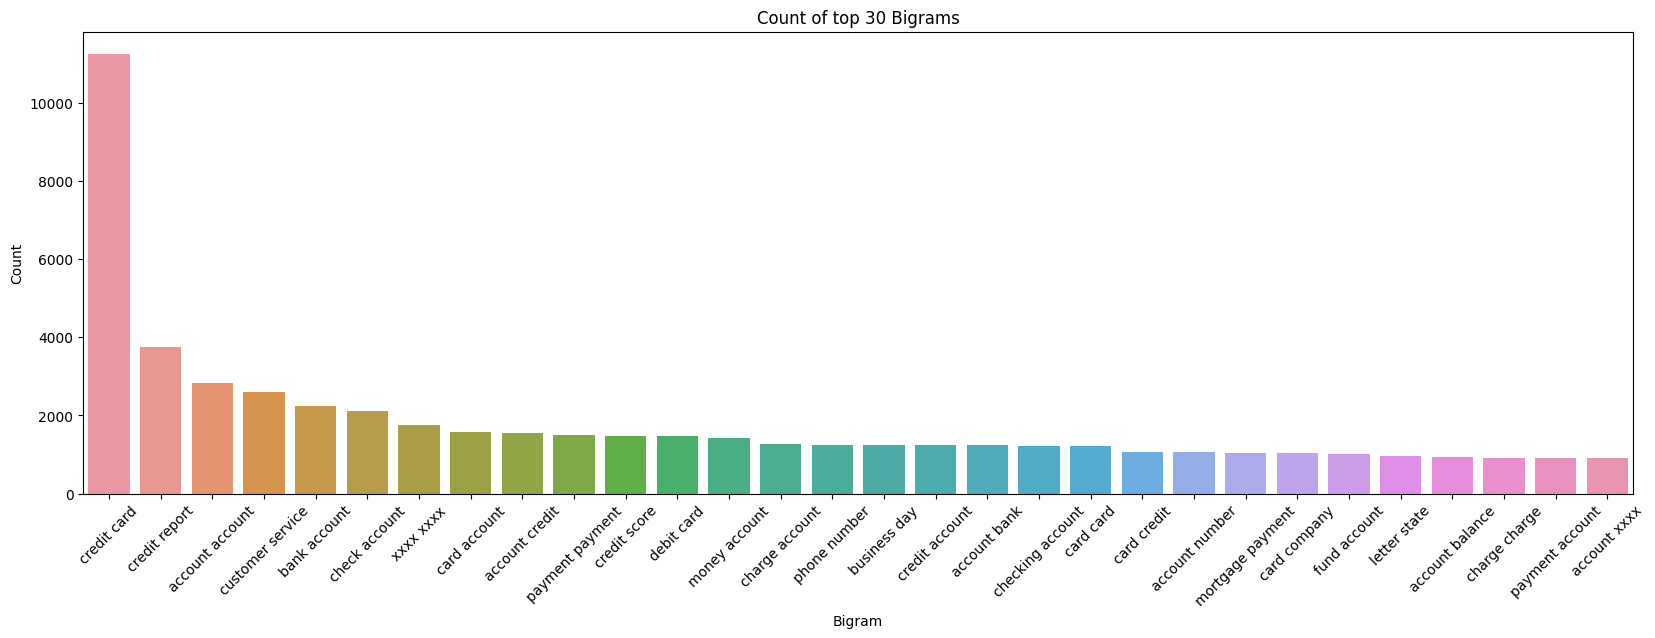

In [32]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['Bigram'], y=df_bigram['Count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bWords = vector.transform(text)
    sum_words = bWords.sum(axis=0) 
    word_frequency = [(word, sum_words[0, id]) for word, id in vector.vocabulary_.items()]
    word_frequency =sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [34]:
#Print the top 10 words in the trigram frequency
top_30_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_30_words, columns = ['Trigram' , 'Count'])
df_trigram.head(10)

,Trigram,Count
0,credit card account,995
1,credit card company,886
2,credit card credit,566
3,charge credit card,519
4,card credit card,469
5,inquiry credit report,465
6,account credit card,440
7,credit reporting agency,326
8,credit report credit,311
9,credit card charge,303


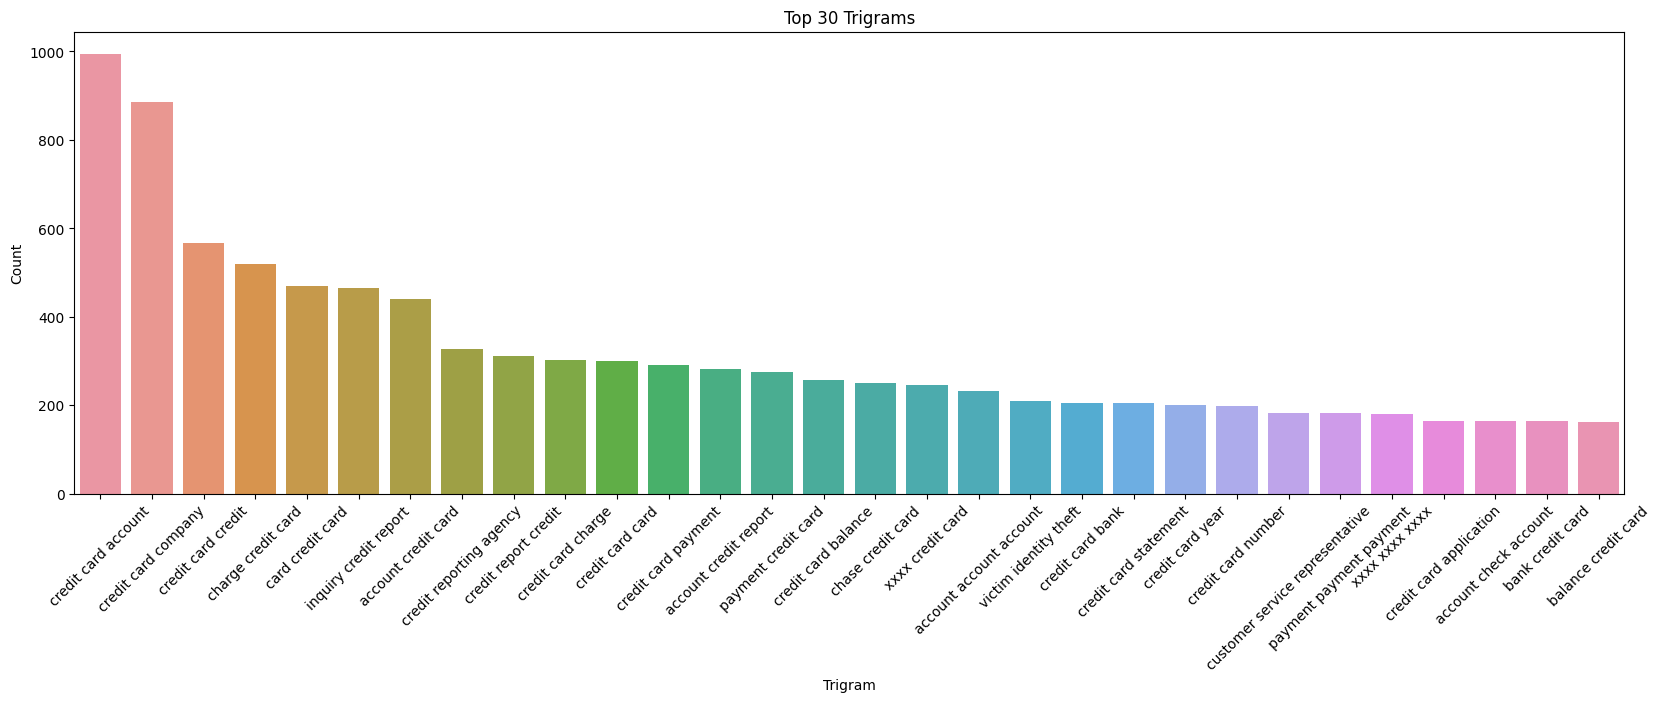

In [35]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['Trigram'], y=df_trigram['Count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Top 30 Trigrams")
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help,good morning my name be XXXX XXXX and I appreciate it if you could help I put a stop to Chase Bank cardmember service \n in I write to Chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n Chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account XXXX change my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent XXXX recording agent,card agent upgrade date agent information order account change date consent XXXX recording agent
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant,Chase Card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,report application identity consent service credit identity applicant,report application identity consent service credit identity applicant
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This is now being reported in my Credit Report and Chase has refused to correct 

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer 
df_clean_copy = df_clean.copy()
tfidf_vector=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

In [39]:
df_clean.shape

(21072, 4)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix=tfidf_vector.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#find best number of topics with help of Coherence model technique
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
dataSet = [x.split() for x in texts]

# Creating a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataSet)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)

# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataSet]

# Create a list of the topic numbers we want to try
topic_num = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40)
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v')
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_num, coherence_scores))
best_topics_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_topics_num)

5


In [43]:
df_clean.shape

(21072, 4)

In [44]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model =  NMF(n_components=num_topics, random_state=40) #write your code here

In [45]:
nmf_model.fit(doc_term_matrix)
len(tfidf_vector.get_feature_names_out())

6673

In [46]:
#Print the Top15 words for each of the topics
#provides the components of the NMF (Non-Negative Matrix Factorization) model and returns components
components = nmf_model.components_ 
words = np.array(tfidf_vector.get_feature_names_out())
topic_Words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = components[i].argsort()[::-1][:15]
    topic_Words.iloc[i] = words[ix]

topic_Words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,deposit,day,branch,xxxx,number,transaction,business,transfer,claim,customer
Topic 2,credit,card,report,inquiry,account,score,company,limit,information,application,debt,letter,year,balance,xxxx
Topic 3,payment,balance,month,fee,statement,day,time,date,pay,mortgage,xxxxxxxx,credit,xxxx,year,error
Topic 4,charge,card,fee,transaction,dispute,merchant,purchase,claim,xxxx,fraud,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,xxxx,property,year,letter,rate,time,document,house,foreclosure,information,sale


#### Observations:
Looking at the topics above, for each topic, we can give a label based on their products/services:
- Topic 1 = Bank Account services
- Topic 2 = Credit card/Prepaid card
- Topic 3 = Others
- Topic 4 = Theft/Dispute Reporting
- Topic 5 = Mortgages/loans

#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(doc_term_matrix)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2], dtype=int64)

In [48]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [49]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help,good morning my name be XXXX XXXX and I appreciate it if you could help I put a stop to Chase Bank cardmember service \n in I write to Chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n Chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help,4
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account XXXX change my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent XXXX recording agent,card agent upgrade date agent information order account change date consent XXXX recording agent,1
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant,Chase Card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,report application identity consent service credit identity applicant,report application identity consent service credit identity applicant,1
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This is now being reported in my Credit Report and Chase has refused

In [50]:
df_clean.shape

(21072, 5)

In [51]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number XXXX claim number is XXXX with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,0
17,With out notice JP Morgan Chase restricted my account by my debit card Tuesday On Thursday I went into A branch after being advised by a customer service representative that my account would actually be closed I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement Ive been called and I was told that it may take two business day stating Tuesday XXXXXXXX would be the date that my funds would be available to withdraw from a bank teller only Now Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently Unfortunately This has put me in an additional financial bind do two fees from late rent late car payments etc I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document This situation is truly affecting my livelihood and they dont seem to want to deal with Me professionally Thank you,with out notice JP Morgan Chase restrict my account by my debit card Tuesday on Thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure I that the fund would post but they ma

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
# creating a back of dataframe for utilizing any mistake while testing
df_clean_bkup = df_clean.copy

In [53]:
#Create the dictionary of Topic names and Topics

# Below code is going to replace with their corresponding replacements based on 
#the mapping specified in the dictionary.
df_clean.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}},inplace=True)

In [54]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help,good morning my name be XXXX XXXX and I appreciate it if you could help I put a stop to Chase Bank cardmember service \n in I write to Chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n Chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help,Mortgage/Loan
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account XXXX change my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent XXXX recording agent,card agent upgrade date agent information order account change date consent XXXX recording agent,Credit card or prepaid card
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant,Chase Card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,report application identity consent service credit identity applicant,report application identity consent service credit identity applicant,Credit card or prepaid card
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This

In [55]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [56]:
#Create the dictionary again of Topic names and Topics

# Below code is going to replace with their corresponding replacements based on 
#the mapping specified in the dictionary.

df_clean.replace({'Topic':{"Bank Account services":0,
                           "Credit card or prepaid card":1,
                           "Others":2,
                            "Theft/Dispute Reporting":3,
                            "Mortgage/Loan":4}},inplace=True)

In [57]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help,good morning my name be XXXX XXXX and I appreciate it if you could help I put a stop to Chase Bank cardmember service \n in I write to Chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n Chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help,morning name stop service ask debt verification statement bank debt mail month debt right information consumer account thank advance help,4
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account XXXX change my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent XXXX recording agent,card agent upgrade date agent information order account change date consent XXXX recording agent,1
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant,Chase Card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,report application identity consent service credit identity applicant,report application identity consent service credit identity applicant,1
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This is now being reported in my Credit Report and Chase has refused

In [58]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened', 'Topic']]

In [59]:
training_data.head()

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services \nIn I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable I am asking the bank to validate the debt Instead I been receiving mail every month from them attempting to collect a debt \nI have a right to know this information as a consumer \n\nChase account XXXX XXXX XXXX XXXX Thanks in advance for your help,4
2,I upgraded my XXXX XXXX card in and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account XXXX changed my anniversary date from XXXXXXXX to XXXXXXXX without my consent XXXX has the recording of the agent who was misled me,1
10,Chase Card was reported on However fraudulent application have been submitted my identity without my consent to fraudulently obtain services Do not extend credit without verifying the identity of the applicant,1
11,On while trying to book a XXXX XXXX ticket I came across an offer for to be applied towards the ticket if I applied for a rewards card I put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made I immediately contacted XXXX and was referred to Chase Bank I then immediately contacted Chase bank within no more than of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why I asked for more information about the XXXX offer and she explained that even if I had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account I asked that the application be withdrawn and the representative obliged This all happened no later than after putting in the application on Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative Chase did in fact go ahead to open a credit account in my name on This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number XXXX claim number is XXXX with chase,0


In [60]:
training_data.shape

(21072, 2)

In [61]:
training_data['Topic'].value_counts()

Topic
0    5236
1    4952
3    4664
4    3871
2    2349
Name: count, dtype: int64

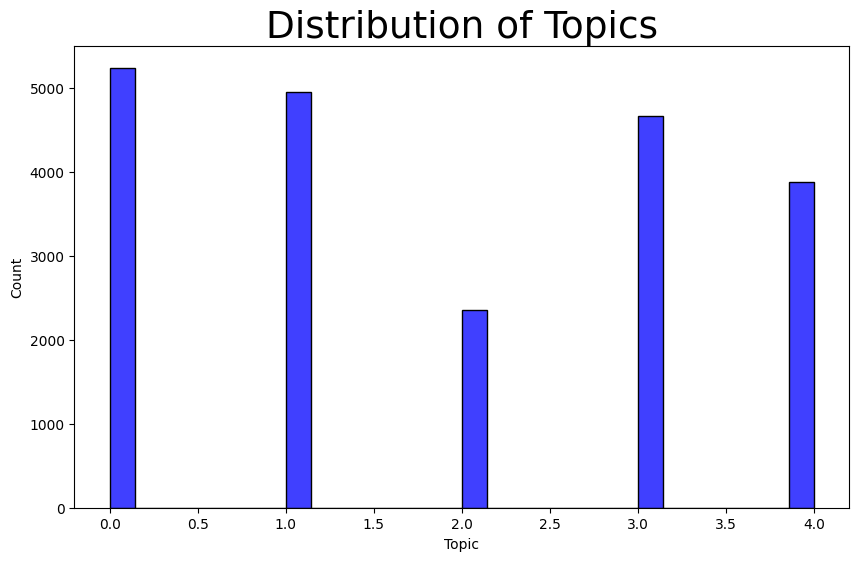

In [62]:
plt.figure(figsize=[10,6])
sns.histplot(data=training_data, x='Topic',color='Blue', )
plt.title("Distribution of Topics", fontsize=27)
plt.show()

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [63]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [64]:

#Write your code to get the Vector count
count_vector = CountVectorizer()
X_train_count = count_vector.fit_transform(training_data['complaint_what_happened'])

# Save word vector
pickle.dump(count_vector.vocabulary_, open("count_vector.pkl", "wb"))

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

In [65]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [66]:
# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [67]:
# Write your code here to build any 3 models and evaluate them using the required metrics
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")


X_train Shape: (15804, 33665)
y_train Shape: (15804,)
X_test Shape: (5268, 33665)
y_test Shape: (5268,)


In [68]:
# Create a function to Evaluate the Models
def model_eval(y_test, y_pred, model_name):
    
    # Display classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

## Model-1: Naive-Bayes

In [69]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

In [70]:
# Run the Multinomial Naive Bayes with default parameters
modelName = 'Naive-Bayes'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [71]:
# Hyperparameter tuning to improve performance of model
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [72]:
# Creating model with best hyperparameter
modelName = 'Naive-Bayes'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [73]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.7703097254326098

CLASSIFICATION REPORT for Naive-Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.84      0.80      1303
Credit card or prepaid card       0.79      0.75      0.77      1274
                     Others       0.68      0.63      0.65       577
    Theft/Dispute Reporting       0.76      0.77      0.76      1162
              Mortgage/Loan       0.82      0.80      0.81       952

                   accuracy                           0.77      5268
                  macro avg       0.76      0.76      0.76      5268
               weighted avg       0.77      0.77      0.77      5268



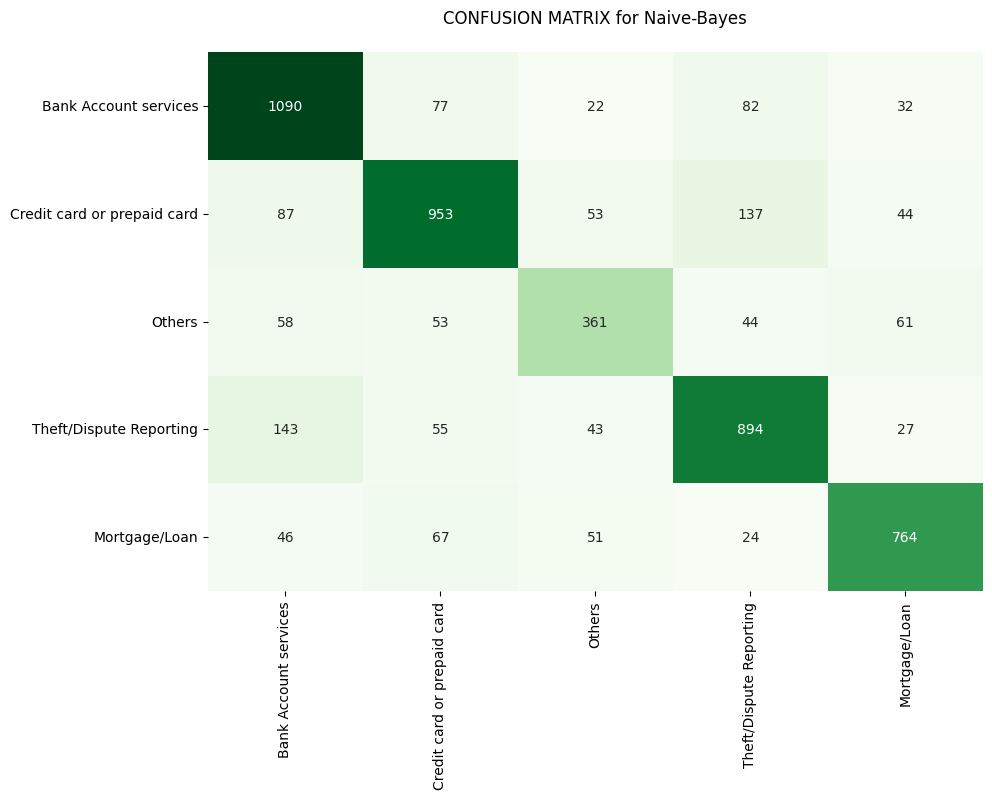

In [74]:
# Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb_tuned, modelName)

In [75]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Naive-Bayes','F1 Score': round(f1_nb, 2)}])
f1_summary

,Model,F1 Score
0,Naive-Bayes,0.77


## Model-2: Logistic Regression

In [76]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [77]:
modelName = 'Logistic Regression'
logisticRegression = LogisticRegression() 
logisticRegression.fit(X_train, y_train)
y_pred_lr = logisticRegression.predict(X_test)

In [78]:
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=logisticRegression, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [79]:
lr_tuned = LogisticRegression(C=1,penalty='l1', solver='saga')
lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [80]:
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9205874522335646

CLASSIFICATION REPORT for Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.94      0.93      1303
Credit card or prepaid card       0.92      0.92      0.92      1274
                     Others       0.93      0.93      0.93       577
    Theft/Dispute Reporting       0.92      0.90      0.91      1162
              Mortgage/Loan       0.92      0.93      0.92       952

                   accuracy                           0.92      5268
                  macro avg       0.92      0.92      0.92      5268
               weighted avg       0.92      0.92      0.92      5268



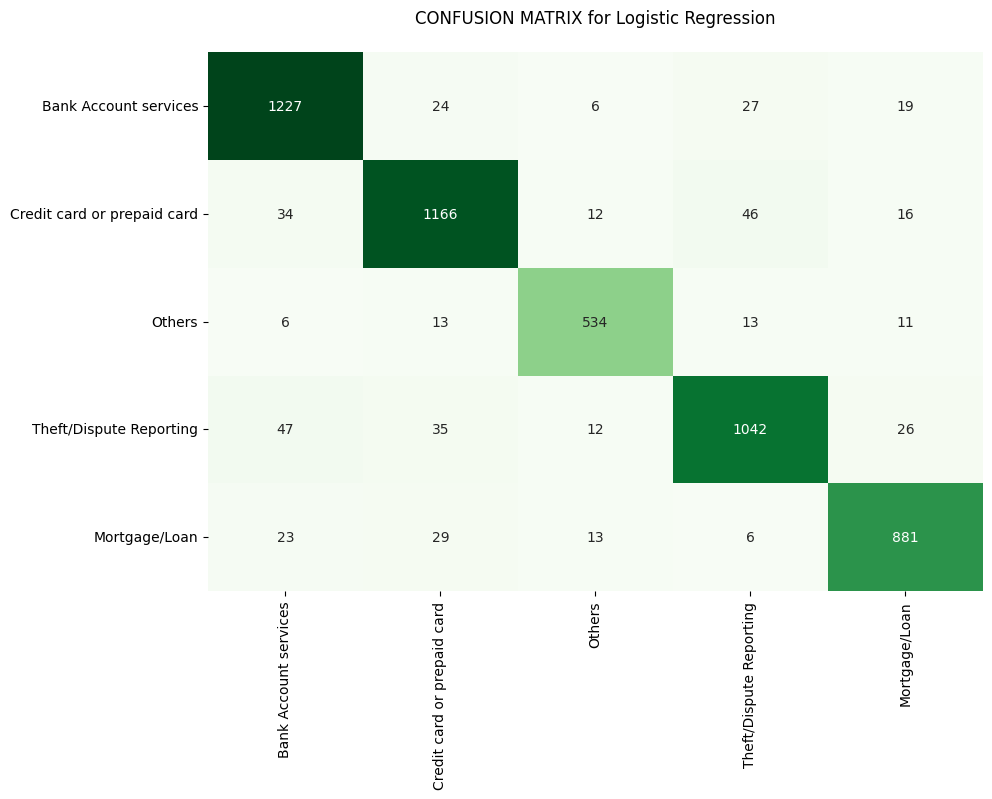

In [81]:
model_eval(y_test, y_pred_lr_tuned, modelName)

In [82]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Logistic Regression', round(f1_lr, 2)]
f1_summary

,Model,F1 Score
0,Naive-Bayes,0.77
1,Logistic Regression,0.92


## Model-3: Decision Tree

In [83]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [84]:
# Run Decision Tree with default hyperparameters
modelName = 'Decision Tree'
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train, y_train)
y_pred_dt =decisionTree.predict(X_test)

In [85]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=decisionTree, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 10}


In [86]:
# Creating model with best hyperparameter
decisionTree_tuned = DecisionTreeClassifier(criterion='gini',max_depth=25,min_samples_leaf=15,)
decisionTree_tuned.fit(X_train, y_train)
y_pred_dt_tuned = decisionTree_tuned.predict(X_test)

In [87]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7912338172688458

CLASSIFICATION REPORT for Decision Tree

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.83      0.81      1303
Credit card or prepaid card       0.82      0.81      0.82      1274
                     Others       0.78      0.81      0.80       577
    Theft/Dispute Reporting       0.76      0.71      0.73      1162
              Mortgage/Loan       0.80      0.81      0.80       952

                   accuracy                           0.79      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.79      0.79      0.79      5268



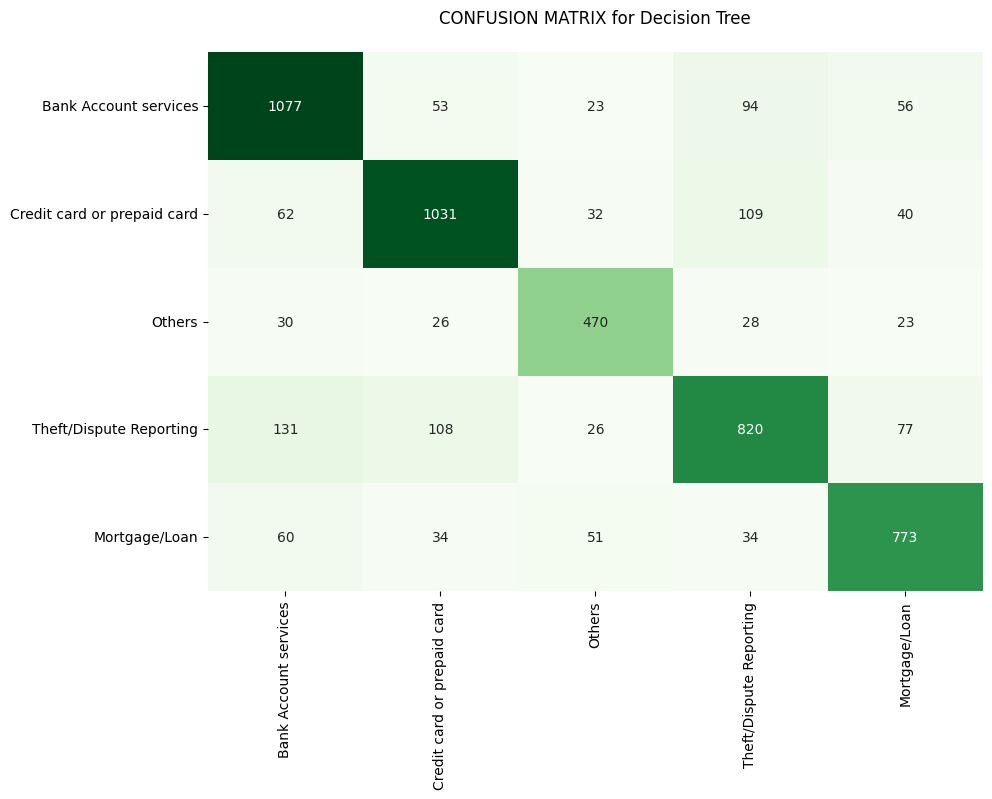

In [88]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, modelName)

In [89]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Naive-Bayes,0.77
1,Logistic Regression,0.92
2,Decision Tree,0.79


## Observations:
- #### Based on the F1 score of all the 3 models,`Logistic Regression` performance is better than other `Naive-Bayes` and `Dicision Tree`. It's F1 score is `0.92`

In [90]:
# loading the saved Logistic Regression model as pickle file in the system
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

In [91]:
# Function to predict a topic for custom text
def topic_predicter(text):
    
    target_names = ["Bank Account services", "Credit card/Prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]
    load_vector = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_count = load_vector.transform(text)
    X_tfidf = load_tfidf.transform(X_count)
    prediction = load_model.predict(X_tfidf)

    return target_names[prediction[0]]

In [92]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,unwanted service activated and money deducted automatically
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Patna?


In [96]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I'm having trouble accessing my online banking account.","The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.","There seems to be a fraudulent transaction on my debit card.","I have a question about the terms and conditions of my mortgage agreement.","I want to report a stolen credit card and unauthorized charges.","I'm experiencing technical issues with the mobile banking app.","I need help with understanding the fees on my savings account.","There's an error in the interest calculation for my personal loan.","I want to inquire about the process for applying for a new credit card."]})

In [97]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,I'm having trouble accessing my online banking account.,Bank Account services
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit card/Prepaid card
2,There seems to be a fraudulent transaction on my debit card.,Theft/Dispute Reporting
3,I have a question about the terms and conditions of my mortgage agreement.,Mortgage/Loan
4,I want to report a stolen credit card and unauthorized charges.,Credit card/Prepaid card
5,I'm experiencing technical issues with the mobile banking app.,Bank Account services
6,I need help with understanding the fees on my savings account.,Bank Account services
7,There's an error in the interest calculation for my personal loan.,Mortgage/Loan
8,I want to inquire about the process for applying for a new credit card.,Credit card/Prepaid card


## Conclusion:
- #### Logistic Regression model is predicting well on given custom data